# YOLOX-S-512 - Boxes Detector - Training

- Create YOLO folder structure (images/labels)
- Convert annotations in COCO format
- Generate YOLOX python file (one per fold)
- Train each fold

### V3.1: YOLOX-S: 48263 slides, 1 class, GIOU Loss - CV4 with multilabel, image size, bb surface ratio, mean, std - Noisy images/boxes kept.
- 69168 but 154 (BBx: 162) duplicates in train removed to avoid leak on train/validation => 69014 (duplicated in test kept), Train: **48263 (BBx: 52586)**, Test: 20751
- Image size=512, Epoch=150, BS=16, multiscale=3, hsv_prob = 0.05, mixup=0.80, no background images, CV4 AP@0.95=0.944/0.945/0.944/0.942

In [1]:
import sys
sys.path.append("../code/src")
import cdc
from cdc.common.utils import *
from cdc.common.constants import *
from cdc.yolo.tools import *
from cdc.utils.imaging import *

/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import numpy as np
import pandas as pd
import glob, os
import json
import wandb
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=0.8)
import time, os, random, shutil
from tqdm.auto import tqdm
import torch
import PIL
from PIL import Image
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, StratifiedGroupKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from imagededup.methods import PHash
from globox.boundingbox import BoundingBox, BoxFormat
from globox.annotation import Annotation
from globox.annotationset import AnnotationSet

In [3]:
print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("CV2", cv2.__version__)

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy 1.26.4
Pandas 2.2.2
CV2 4.10.0


In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [36]:
VERSION = "v3.1"
DATA_ROOT = "../data"
DATA_HOME = "../yolo_models/"
CONVERT_HOME = DATA_HOME + "data_coco_%s/"%VERSION
LABELS_HOME = os.path.join(DATA_HOME, "data_%s/labels/"%VERSION)
TRAIN_HOME = os.path.join(DATA_HOME, "data_%s/images/"%VERSION)
os.makedirs(LABELS_HOME, exist_ok=True)
IMAGES_HOME = os.path.join(DATA_ROOT, "images_cytologia")

SEEDS = [42]
seed_everything(SEEDS[0])
FOLDS = 4
SURFACE_BINS = 3
SURFACE_RATIO_BINS = 4

NOISY = []

## Prepare/convert data to COCO format 

In [ ]:
# Copy all images to a new folder to fit YOLO format before converting to COCO. It will take a few minutes.
shutil.copytree(IMAGES_HOME, TRAIN_HOME)

In [9]:
# Load CV split
train_pd = pd.read_parquet(os.path.join(DATA_ROOT, "cv4_seed42_multilabel.parquet")) # BBx from train dataset
print(train_pd.shape)

(48263, 42)


In [11]:
# Create BBX label files with single class (0)
for idx, row in tqdm(train_pd.iterrows(), total=len(train_pd)):
    filename = row["filename"]
    name = row["NAME"]
    bbs = row["bbx"]
    img_height = row["img_height"]
    img_width = row["img_width"]
    w, h = Image.open(os.path.join(TRAIN_HOME, name)).size
    assert(w == img_width)
    assert(h == img_height)
    if len(bbs) > 0:
        file = "%s.txt" % (name.replace(".jpg", ""))
        with open(LABELS_HOME + file, "w") as f:
            for bb in bbs:
                x1, x2, y1, y2, klass = bb
                klass = 0
                x_,y_,w_,h_ = convert_tlrb_to_yolo((w, h), (x1, x2, y1, y2))
                f.write("%d %.15f %.15f %.15f %.15f%s"%(klass, x_,y_,w_,h_, CRLF))

  0%|          | 0/48263 [00:00<?, ?it/s]

In [12]:
# Read Yolo annotations. It should return:
# ┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
# ┃ Label ┃ Images ┃ Boxes ┃
# ┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
# │ 0     │  48263 │ 52586 │
# ├───────┼────────┼───────┤
# │ Total │  48263 │ 52586 │
# └───────┴────────┴───────┘
yolo_annotations = AnnotationSet.from_yolo_v5(
    folder=LABELS_HOME,
    image_folder=TRAIN_HOME
)
yolo_annotations.show_stats()

      Database Stats      
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Label ┃ Images ┃ Boxes ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0     │  48263 │ 52586 │
├───────┼────────┼───────┤
│ Total │  48263 │ 52586 │
└───────┴────────┴───────┘

In [13]:
def extract_label(x1, x2, y1, y2, bbx):
    label = None
    for bb in bbx:
        if (x1 == bb[0]) and (x2 == bb[1]) and (y1 == bb[2]) and (y2 == bb[3]):
            label = bb[4]
    return label

(52586, 8)


/tmp/ipykernel_293514/2882554473.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_pd["label"] = results_pd[["x1", "x2", "y1", "y2", "bbx"]].apply(lambda x: extract_label(x[0], x[1], x[2], x[3], x[4]), axis=1)


,NAME,class,slide_width,slide_height,x1,y1,x2,y2,roi_width,roi_height,slide_surface,roi_surface,roi_surface_ratio,roi_surface_bin,roi_surface_ratio_bin,filename,bbs,multilabel,fold_s42,bbx,label,label_name
0,00008cef-c.jpg,0,368,370,110,114,262,262,152,148,136160,22496,16.521739,1,2,images_cytologia/00008cef-c.jpg,1,0,1,"[[110, 262, 114, 262, 0]]",0,PNN
1,00010aae-3.jpg,0,352,357,95,82,252,275,157,193,125664,30301,24.112713,2,3,images_cytologia/00010aae-3.jpg,1,3,0,"[[95, 252, 82, 275, 3]]",3,EO
2,00016779-d.jpg,0,352,357,91,107,256,247,165,140,125664,23100,18.382353,1,2,images_cytologia/00016779-d.jpg,1,3,0,"[[91, 256, 107, 247, 3]]",3,EO
3,0003ab57-1.jpg,0,368,369,113,110,259,261,146,151,135792,22046,16.235124,1,2,images_cytologia/0003ab57-1.jpg,1,0,0,"[[113, 259, 110, 261, 0]]",0,PNN
4,000a7dc3-d.jpg,0,368,369,134,130,235,232,101,102,135792,10302,7.586603,0,0,images_cytologia/000a7dc3-d.jpg,1,10,2,"[[134, 235, 130, 232, 10]]",10,LyB


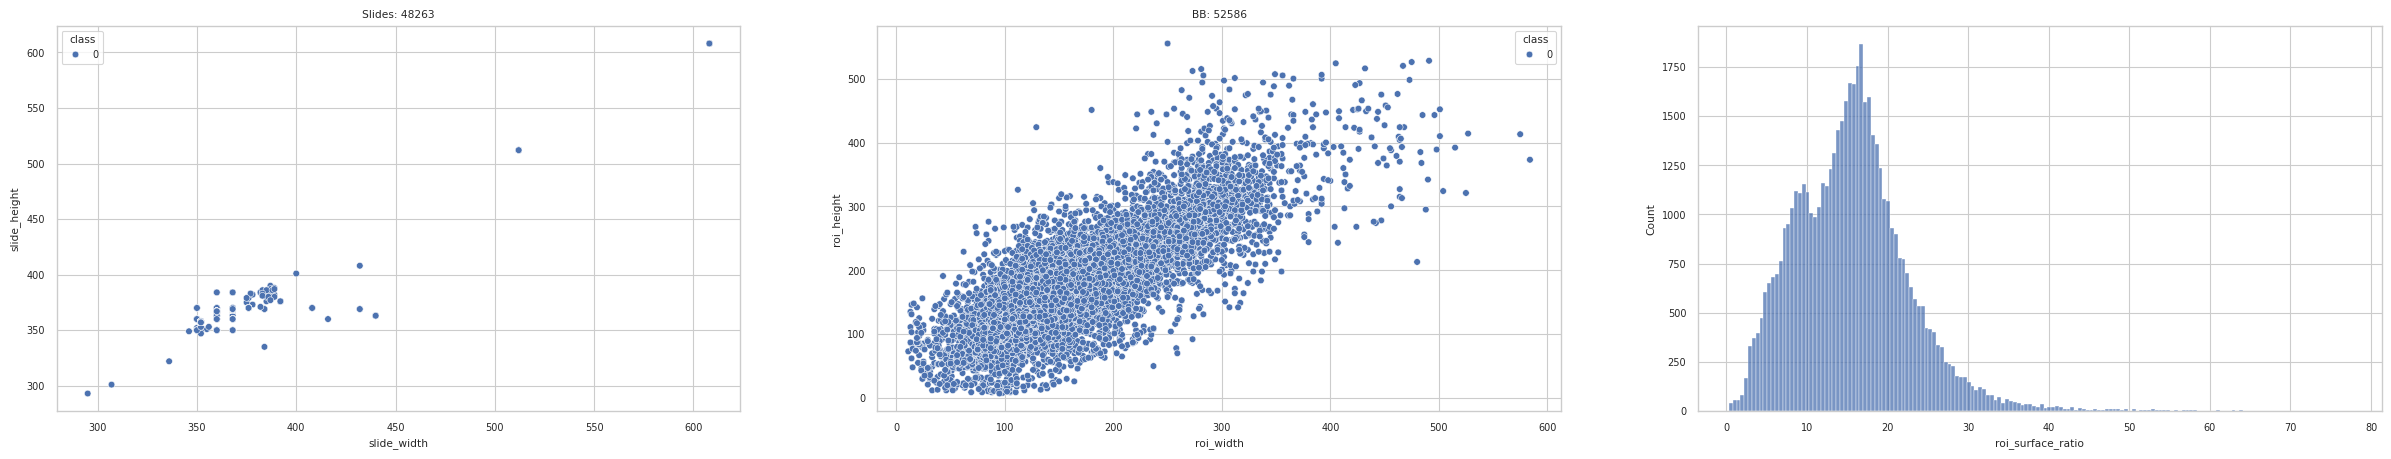

In [17]:
# Display some stats
results = []
for annotation in yolo_annotations:
    for bb in annotation.boxes:
        results.append((annotation.image_id, bb.label, annotation.image_size[0], annotation.image_size[1], bb.xmin, bb.ymin, bb.xmax, bb.ymax))
results_pd = pd.DataFrame(results, columns=["NAME", "class", "slide_width", "slide_height", "x1", "y1", "x2", "y2"])
print(results_pd.shape)
results_pd["x1"] = results_pd["x1"].apply(lambda x: np.round(x)).astype(np.int32)
results_pd["y1"] = results_pd["y1"].apply(lambda x: np.round(x)).astype(np.int32)
results_pd["x2"] = results_pd["x2"].apply(lambda x: np.round(x)).astype(np.int32)
results_pd["y2"] = results_pd["y2"].apply(lambda x: np.round(x)).astype(np.int32)
results_pd["roi_width"] = results_pd["x2"] - results_pd["x1"]
results_pd["roi_height"] = results_pd["y2"] - results_pd["y1"]
results_pd["slide_surface"] = results_pd["slide_width"] * results_pd["slide_height"]
results_pd["roi_surface"] = results_pd["roi_width"] * results_pd["roi_height"]
results_pd["roi_surface_ratio"] = results_pd["roi_surface"]*100./results_pd["slide_surface"]
results_pd["%s_bin" % "roi_surface"] = pd.qcut(results_pd["roi_surface"], SURFACE_BINS, labels=range(SURFACE_BINS)).astype(np.int16)
results_pd["%s_bin" % "roi_surface_ratio"] = pd.qcut(results_pd["roi_surface_ratio"], SURFACE_RATIO_BINS, labels=range(SURFACE_RATIO_BINS)).astype(np.int16)
results_pd["class"] = results_pd["class"].astype(np.int16)
results_pd = pd.merge(results_pd, train_pd[["NAME", "filename", "bbs", "multilabel", "fold_s42", "bbx", "img_width", "img_height"]].rename(columns={'img_width':'slide_width', 'img_height':'slide_height'}), on=["NAME", "slide_height", "slide_width"], how="left")
results_pd["label"] = results_pd[["x1", "x2", "y1", "y2", "bbx"]].apply(lambda x: extract_label(x[0], x[1], x[2], x[3], x[4]), axis=1)
results_pd["label_name"] = results_pd["label"].map(class_mapping)
display(results_pd.head())
fig, ax = plt.subplots(1, 3, figsize=(30,5))
d = sns.scatterplot(data=results_pd, x="slide_width", y="slide_height", hue="class", ax=ax[0])
d = sns.scatterplot(data=results_pd, x="roi_width", y="roi_height", hue="class", ax=ax[1])
d = sns.histplot(data=results_pd, x="roi_surface_ratio", ax=ax[2])
d = ax[0].set_title("Slides: %d" % results_pd["NAME"].nunique())
d = ax[1].set_title("BB: %d" % results_pd.shape[0])
plt.show()

42 0 (39472, 22) (13114, 22) 36176 12087 []
42 1 (39445, 22) (13141, 22) 36206 12057 []
42 2 (39410, 22) (13176, 22) 36218 12045 []
42 3 (39431, 22) (13155, 22) 36189 12074 []


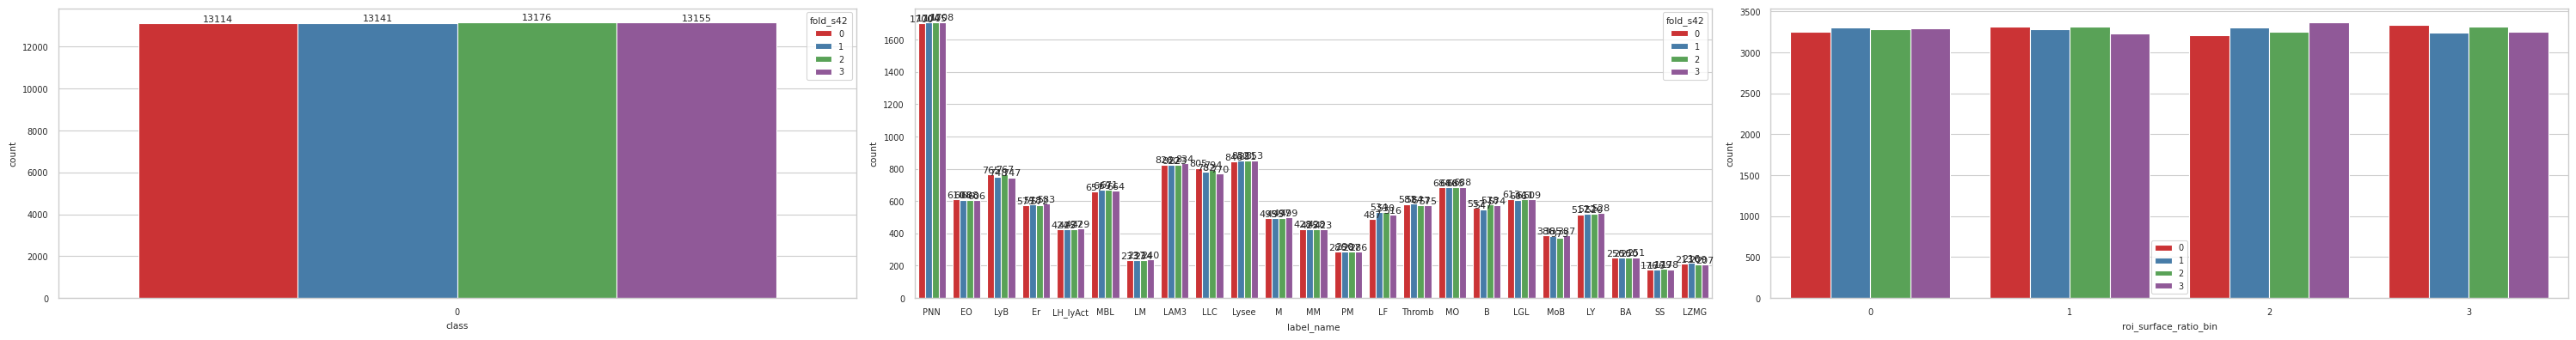

In [18]:
# Sanity check on cross-validation
for seed_ in SEEDS:
    seed_everything(seed_)

    for fold in sorted(results_pd["fold_s%d" % seed_].unique()):
        X_tr, X_va = results_pd[results_pd["fold_s%d" % seed_] != fold], results_pd[results_pd["fold_s%d" % seed_] == fold]      
        print(seed_, fold, X_tr.shape, X_va.shape,
              X_tr["filename"].nunique(), X_va["filename"].nunique(),
              np.intersect1d(X_tr["filename"].values, X_va["filename"].values))
        
    fig, ax = plt.subplots(1, 3, figsize=(30,4))
    d = sns.countplot(x="class", data=results_pd, hue="fold_s%d" % seed_, ax=ax[0], palette="Set1")
    for i in ax[0].containers:
        ax[0].bar_label(i,fmt='%d', fontsize=8)    
    d = sns.countplot(x="label_name", data=results_pd, hue="fold_s%d" % seed_, ax=ax[1], palette="Set1")
    for i in ax[1].containers:
        ax[1].bar_label(i,fmt='%d', fontsize=8)         
    d = sns.countplot(x="roi_surface_ratio_bin", data=results_pd, hue="fold_s%d" % seed_, ax=ax[2], palette="Set1")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
      
    print()

results_pd.to_parquet(os.path.join(DATA_HOME, "yolox_train_with_%dfolds_%s.parquet" % (FOLDS, VERSION)), index=False)

In [19]:
results_pd.head()

,NAME,class,slide_width,slide_height,x1,y1,x2,y2,roi_width,roi_height,slide_surface,roi_surface,roi_surface_ratio,roi_surface_bin,roi_surface_ratio_bin,filename,bbs,multilabel,fold_s42,bbx,label,label_name
0,00008cef-c.jpg,0,368,370,110,114,262,262,152,148,136160,22496,16.521739,1,2,images_cytologia/00008cef-c.jpg,1,0,1,"[[110, 262, 114, 262, 0]]",0,PNN
1,00010aae-3.jpg,0,352,357,95,82,252,275,157,193,125664,30301,24.112713,2,3,images_cytologia/00010aae-3.jpg,1,3,0,"[[95, 252, 82, 275, 3]]",3,EO
2,00016779-d.jpg,0,352,357,91,107,256,247,165,140,125664,23100,18.382353,1,2,images_cytologia/00016779-d.jpg,1,3,0,"[[91, 256, 107, 247, 3]]",3,EO
3,0003ab57-1.jpg,0,368,369,113,110,259,261,146,151,135792,22046,16.235124,1,2,images_cytologia/0003ab57-1.jpg,1,0,0,"[[113, 259, 110, 261, 0]]",0,PNN
4,000a7dc3-d.jpg,0,368,369,134,130,235,232,101,102,135792,10302,7.586603,0,0,images_cytologia/000a7dc3-d.jpg,1,10,2,"[[134, 235, 130, 232, 10]]",10,LyB


In [20]:
# Convert to COCO format. It takes a few minutes per fold.
def convert_to_coco(df, target_folder, images_folder, folder):
    FLAT_HOME = os.path.join(target_folder, "flat")
    flat_folder_home = os.path.join(FLAT_HOME, folder)
    os.makedirs(flat_folder_home, exist_ok=True)    

    df_ = df.groupby(["NAME"])[["x1", "y1", "x2", "y2", "class"]].agg(list).reset_index()
    
    for idx, row in df_.iterrows():
        uid = row["NAME"]

        x1s, y1x, x2s, y2s, klasses = row["x1"], row["y1"], row["x2"], row["y2"], row["class"]
        with open(os.path.join(flat_folder_home, uid.replace(".jpg", ".txt")), "w") as f:                
            for x1, y1, x2, y2, klass in zip(x1s, y1x, x2s, y2s, klasses):
                klass = 0
                f.write(str(klass) + " " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "\r\n")

    annotations = AnnotationSet.from_txt(
            folder=flat_folder_home,
            image_folder=images_folder,
            box_format=BoxFormat.LTRB,
            relative=False,
            file_extension=".txt",
            image_extension=".jpg",
            separator= " ",
            conf_last=False,
            verbose=True,
        )
  
    annotations.save_coco(os.path.join(target_folder, "instances_%s.json" % (folder)), auto_ids=True)
    
    shutil.rmtree(FLAT_HOME)

In [21]:
for seed_ in SEEDS:
    for fold_ in range(FOLDS):
        tmp_folder = os.path.join(CONVERT_HOME, VERSION, "seed_%d" % seed_)
        tmp_folder = os.path.join(tmp_folder, "fold%d" % fold_)
        os.makedirs(tmp_folder, exist_ok=True)

        x_valid = results_pd[results_pd["fold_s%d" % seed_] == fold_]
        x_train = results_pd[results_pd["fold_s%d" % seed_] != fold_]
        x_valid_cleaned = x_valid[~(x_valid["NAME"].isin(NOISY))].copy()
        x_train_cleaned = x_train[~(x_train["NAME"].isin(NOISY))].copy()
        print(x_valid.shape, x_valid_cleaned.shape, x_train.shape, x_train_cleaned.shape)  
            
        convert_to_coco(x_train_cleaned, tmp_folder, TRAIN_HOME, "train_cleaned")
        convert_to_coco(x_valid_cleaned, tmp_folder, TRAIN_HOME, "valid_cleaned")

(13114, 22) (13114, 22) (39472, 22) (39472, 22)


Parsing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12087/12087 [00:38<00:00, 310.72it/s]


(13141, 22) (13141, 22) (39445, 22) (39445, 22)


Parsing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12057/12057 [00:33<00:00, 365.35it/s]


(13176, 22) (13176, 22) (39410, 22) (39410, 22)


Parsing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12045/12045 [00:33<00:00, 362.78it/s]


(13155, 22) (13155, 22) (39431, 22) (39431, 22)


Parsing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12074/12074 [00:33<00:00, 360.98it/s]


## YOLOX-S 512

In [37]:
IMAGE_SIZE = 512
MAX_EPOCHS = 150
YOLO_SIZE = "s"
IOU_LOSS_TYPE = "giou"
NO_AUG_EPOCHS = 15
NUM_WORKERS = 6
EVAL_INTERVAL = 10
FULL_TRAIN = False

ABS_TRAIN_HOME = os.path.abspath(TRAIN_HOME)
ABS_TEST_HOME = os.path.abspath(TRAIN_HOME)
ANNOTATIONS_TRAIN = os.path.join(ABS_TRAIN_HOME, "annotations")
ANNOTATIONS_TEST = os.path.join(ABS_TEST_HOME, "annotations")
os.makedirs(ANNOTATIONS_TRAIN, exist_ok=True)
os.makedirs(ANNOTATIONS_TEST, exist_ok=True)

In [39]:
for seed_ in SEEDS:
    for fold_ in range(FOLDS):
        tmp_folder = os.path.join(CONVERT_HOME, VERSION, "seed_%d" % seed_)
        tmp_folder = os.path.join(tmp_folder, "fold%d" % fold_)
        
        shutil.copy(tmp_folder + "/" "instances_train_cleaned.json", ANNOTATIONS_TRAIN)
        shutil.copy(tmp_folder + "/" "instances_valid_cleaned.json", ANNOTATIONS_TRAIN)        

        train_name = "instances_train_cleaned_%s_seed_%d_fold%d.json" % (VERSION, seed_, fold_)
        valid_name = "instances_valid_cleaned_%s_seed_%d_fold%d.json" % (VERSION, seed_, fold_)
        test_name =  "instances_test_%s_seed_%d_fold%d.json" % (VERSION, seed_, fold_)
        os.rename(ANNOTATIONS_TRAIN + "/" + "instances_train_cleaned.json",  ANNOTATIONS_TRAIN + "/" + train_name)
        os.rename(ANNOTATIONS_TRAIN + "/" + "instances_valid_cleaned.json",  ANNOTATIONS_TRAIN + "/" + valid_name)
        
        yolo_size = YOLO_SIZE

        if yolo_size == "l":
            yolo_depth = 1.0
            yolo_width =  1.0
        elif yolo_size == "x":
            yolo_depth = 1.33
            yolo_width =  1.25
        elif yolo_size == "m":
            yolo_depth = 0.67
            yolo_width =  0.75            
        else:
            yolo_depth = 0.33
            yolo_width =  0.50
        
        # YoloX
        yolox_str = f'''
import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = {yolo_depth}
        self.width = {yolo_width}
        self.iou_loss_type = "{IOU_LOSS_TYPE}"
        
        self.input_size = ({IMAGE_SIZE}, {IMAGE_SIZE})
        self.test_size = ({IMAGE_SIZE}, {IMAGE_SIZE})
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.seed = {seed_}

        # Define yourself dataset path
        self.data_dir = "{ABS_TRAIN_HOME}"
        self.train_ann = "{train_name}"
        self.val_ann = "{valid_name}"
        self.test_ann = "{test_name}"

        self.num_classes = 1
        self.max_epoch = {MAX_EPOCHS}
        self.data_num_workers = {NUM_WORKERS}
        self.eval_interval = {EVAL_INTERVAL}
        self.save_history_ckpt = False

        self.multiscale_range = 3 # 5
        self.mosaic_prob = 1.0 # 0.20
        self.mixup_prob = 0.80 # 0.40
        self.hsv_prob = 0.05
        self.degrees = 30.0
        
        self.no_aug_epochs = {NO_AUG_EPOCHS}

        '''
        
        with open('../code/src_object_detector/YOLOX/exps/example/custom/yolox_%s_%s_%d_seed_%d_fold%s.py'%(yolo_size, VERSION.replace(".", ""), IMAGE_SIZE, seed_, fold_), mode='w') as file:
            file.write(yolox_str)      

        
        print(f"""python ./tools/train.py -f ./exps/example/custom/yolox_{yolo_size}_{VERSION.replace(".", "")}_{IMAGE_SIZE}_seed_{seed_}_fold{fold_}.py -d 1 -b 16 --fp16 -o -c ./yolox_{yolo_size}.pth""")

python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold0.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth
python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold1.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth
python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold2.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth
python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold3.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth


In [28]:
# Sanity check for fold0
train_annotations = AnnotationSet.from_coco(os.path.join(TRAIN_HOME, "annotations", "instances_train_cleaned_%s_seed_42_fold0.json" % VERSION))
valid_annotations = AnnotationSet.from_coco(os.path.join(TRAIN_HOME, "annotations", "instances_valid_cleaned_%s_seed_42_fold0.json" % VERSION))

In [29]:
train_annotations.show_stats()

      Database Stats      
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Label ┃ Images ┃ Boxes ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0     │  36176 │ 39472 │
├───────┼────────┼───────┤
│ Total │  36176 │ 39472 │
└───────┴────────┴───────┘

In [30]:
valid_annotations.show_stats()

      Database Stats      
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Label ┃ Images ┃ Boxes ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0     │  12087 │ 13114 │
├───────┼────────┼───────┤
│ Total │  12087 │ 13114 │
└───────┴────────┴───────┘

## Train each fold for 150 epochs

In [31]:
if not os.path.exists("../code/src_object_detector/YOLOX/yolox_s.pth"):
    print("Please copy yolox_s.pth under ../code/src_object_detector/YOLOX folder")

In [40]:
# You can also run the lines below in a terminal.

In [ ]:
!cd ../code/src_object_detector/YOLOX;python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold0.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth

In [ ]:
!cd ../code/src_object_detector/YOLOX;python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold1.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth

In [ ]:
!cd ../code/src_object_detector/YOLOX;python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold2.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth

In [ ]:
!cd ../code/src_object_detector/YOLOX;python ./tools/train.py -f ./exps/example/custom/yolox_s_v31_512_seed_42_fold3.py -d 1 -b 16 --fp16 -o -c ./yolox_s.pth